In [1]:
pip install rouge

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=fa0fbfcafde7a19cb07adb2d72a2268aded784bbdb630214b87596b8811aaa36
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses


In [4]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.7 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import sacremoses
from transformers import pipeline, set_seed
from transformers import BioGptTokenizer, BioGptForCausalLM
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import cv2
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Conv2D, Concatenate, Flatten, Add, Dropout, GRU
import random
import datetime
from nltk.translate.bleu_score import sentence_bleu
import nltk
import warnings
warnings.filterwarnings('ignore')
import graphviz
import pydot
#import torch
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time
from rouge import Rouge
from numpy import arange

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### multihead attention (attention layer)

In [7]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [8]:
def scaled_dot_product_attention(q, k, v, mask):

    """Calculate the attention weights.
     q, k, v must have matching leading dimensions.
     k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
     The mask has different shapes depending on its type(padding or look ahead)
     but it must be broadcastable for addition.

     Args:
       q: query shape == (..., seq_len_q, depth)
       k: key shape == (..., seq_len_k, depth)
       v: value shape == (..., seq_len_v, depth_v)
       mask: Float tensor with shape broadcastable
             to (..., seq_len_q, seq_len_k). Defaults to None.

     Returns:
       output, attention_weights
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
       # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)


        return output, attention_weights

## load dataset and defined function

In [11]:
# load the dataset generated from DataPreprocessing_and_Image_feature_generating notebook
train_dataset = pd.read_csv('/content/drive/MyDrive/dissertation/CNN_LSTM/Train_Data.csv')
test_dataset = pd.read_csv('/content/drive/MyDrive/dissertation/CNN_LSTM/Test_Data.csv')
cv_dataset = pd.read_csv('/content/drive/MyDrive/dissertation/CNN_LSTM/CV_Data.csv')

In [12]:
test_dataset.loc[test_dataset["Person_id"]=="image/CXR2558_IM-1062_0"]

,Person_id,Image1,Image2,Report
1,image/CXR2558_IM-1062_0,image/CXR2558_IM-1062-10001.png,image/CXR2558_IM-1062-1001.png,startseq there no focal consolidation . there...


In [14]:
train_dataset.shape, test_dataset.shape, cv_dataset.shape

((2771, 4), (373, 4), (563, 4))

In [15]:
pad_size = 153   # Max length of reports (check in the reprocessing notebook)
X_train, X_test, X_cv = train_dataset['Person_id'], test_dataset['Person_id'], cv_dataset['Person_id'][:546]
y_train, y_test, y_cv = train_dataset['Report'], test_dataset['Report'], cv_dataset['Report'][:546]

In [16]:
#token reports
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(y_train.values)

In [17]:
f = open('/content/drive/MyDrive/dissertation/Image_features_attention.pickle','rb') # load the image features generated from DataPreprocessing_and_Image_feature_generating notebook
Xnet_Features = pickle.load(f)
f.close()

In [18]:
# load the pre train GloVe token vector representations
embeddings_dict = {}
with open("/content/drive/MyDrive/dissertation/glove.42B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [19]:
embeddings_dict["each"].shape
#use 300d tuple to represent "each" natural word.

(300,)

In [20]:
vocab_size = len(tokenizer.word_index.keys()) + 1

In [21]:
vocab_size

1418

In [22]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    if word in embeddings_dict.keys():
        vec = embeddings_dict[word]
        embedding_matrix[i] = vec
    else:
        continue

In [23]:
def load_image(id_, report):
    '''Loads the Image Features with their corresponding Ids'''
    img_feature = Xnet_Features[id_.decode('utf-8')][0]
    return img_feature, report

In [24]:
BATCH_SIZE = 16
def create_dataset(img_name, caption):

    dataset = tf.data.Dataset.from_tensor_slices((img_name, caption))

  # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_image, [item1, item2], [tf.float32, tf.string]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
    dataset = dataset.shuffle(500).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [25]:
train_generator = create_dataset(X_train, y_train)
cv_generator = create_dataset(X_cv, y_cv)

In [26]:
def bytes_to_string(arr):
    '''The generator gives provides data in bytes. This function converts them back to strings for manipulation'''
    for i in range(len(arr)):
        arr[i] = arr[i].decode('utf-8')
    return arr

In [27]:
#original
def convert(images, reports):
    '''This function takes the batch of data and converts them into a new dataset(A WORD BY WORD DATASET)'''
    imgs = []
    in_reports = []
    out_reports = []
    for i in range(len(images)):
        sequence = [tokenizer.word_index[e] for e in reports[i].split() if e in tokenizer.word_index.keys()]
      #  print(sequence)
      #This loop iterates over the indices of the images list. It retrieves the corresponding report from the reports
      #list using the index i. The report is then split into individual words using .split(). For each word e in the split report,
      #the code checks if it is present in the word_index of the tokenizer object. If it is, the corresponding word index is
      #retrieved and added to the sequence list.
        for j in range(1,len(sequence)):

            in_seq = sequence[:j]
            out_seq = sequence[j]
            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)

            imgs.append(images[i])
          #  print(in_seq)
            in_reports.append(in_seq)
           # print(out_seq)
            out_reports.append(out_seq)

    return np.array(imgs), np.array(in_reports), np.array(out_reports)

In [28]:
np.random.seed(42)

##fixing tensorflow RS
tf.random.set_seed(32)

##python RS
random.seed(12)

## model without attention layer (only cnn + lstm rnn)

In [ ]:
from tensorflow.keras.layers import Attention

input1 = Input(shape=(2048,), name='Image_1')
dense1 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')(input1)

input2 = Input(shape=(153,), name='Text_Input')
emb_layer = Embedding(input_dim = vocab_size, output_dim = 300, input_length=153, mask_zero=True, trainable=False,
                weights=[embedding_matrix], name="Embedding_layer")
emb = emb_layer(input2)

LSTM1 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(emb)
#LSTM1_output = LSTM1(emb)
print("The shape of 'LSTM1' is " + str(LSTM1.shape))

LSTM2 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")
LSTM2_output = LSTM2(LSTM1)

dropout1 = Dropout(0.6, name='dropout1')(LSTM2_output)


dec =  tf.keras.layers.Add()([dense1, dropout1])

fc1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed = 63), name='fc1')
fc1_output = fc1(dec)
dropout2 = Dropout(0.5, name='dropout2')(fc1_output)
output_layer = Dense(vocab_size, activation='softmax', name='Output_layer')
output = output_layer(dropout2)


#output_layer(fc_1)

encoder_decoder = Model(inputs = [input1, input2], outputs = output)
encoder_decoder.summary()

The shape of 'LSTM1' is (None, 153, 256)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text_Input (InputLayer)        [(None, 153)]        0           []                               
                                                                                                  
 Embedding_layer (Embedding)    (None, 153, 300)     425400      ['Text_Input[0][0]']             
                                                                                                  
 LSTM1 (LSTM)                   (None, 153, 256)     570368      ['Embedding_layer[0][0]']        
                                                                                                  
 Image_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                   

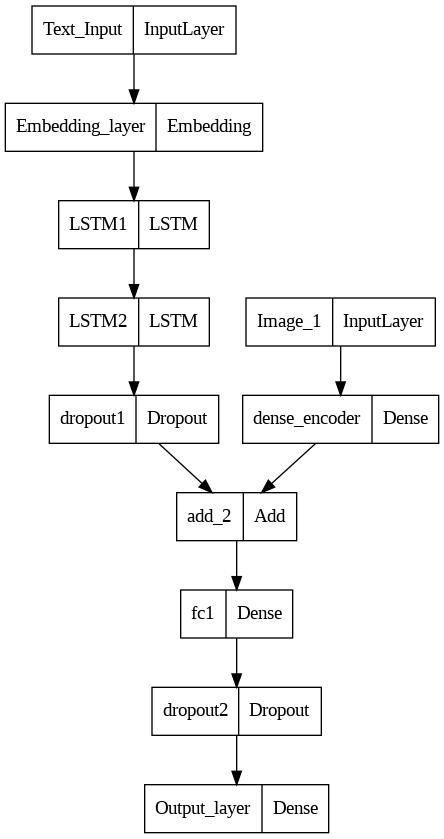

In [ ]:
tf.keras.utils.plot_model(encoder_decoder)

## model with self attention 1 (after text embedding and image imput)

In [ ]:
#resouces: https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
#https://machinelearningmastery.com/how-to-implement-multi-head-attention-from-scratch-in-tensorflow-and-keras/
#https://data-science-blog.com/blog/2021/04/07/multi-head-attention-mechanism/

In [ ]:
input1 = Input(shape=(2048,), name='Image_1')

temp_mha = MultiHeadAttention(num_heads=4, d_model=2048)
out1, attn = temp_mha(v=input1, k=input1, q=input1, mask=None)

dense1 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')(out1)

dense1 = tf.keras.layers.Reshape((dense1.shape[-1],), name= "reshape")(dense1)

input2 = Input(shape=(153,), name='Text_Input')
emb_layer = Embedding(input_dim = vocab_size, output_dim = 300, input_length=153, mask_zero=True, trainable=False,
                weights=[embedding_matrix], name="Embedding_layer")
emb = emb_layer(input2)

#dense2 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder2')(emb)

temp_mha = MultiHeadAttention(num_heads=4, d_model=300)
out2, attn = temp_mha(v=emb, k=emb, q=emb, mask=None)
#print(out.shape)

LSTM1 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(out2)
#LSTM1_output = LSTM1(emb)

LSTM2 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")

LSTM2_output = LSTM2(LSTM1)

dropout1 = Dropout(0.4, name='dropout1')(LSTM2_output)


dec =  tf.keras.layers.Add()([dense1, dropout1])

fc1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed = 63), name='fc1')
fc1_output = fc1(dec)
dropout2 = Dropout(0.4, name='dropout2')(fc1_output)
output_layer = Dense(vocab_size, activation='softmax', name='Output_layer')
output = output_layer(dropout2)
#output = tf.keras.layers.Reshape((output.shape[-1],))(output)
#output = tf.reshape(output , [output.shape[0], output.shape[-1]])

encoder_decoder = Model(inputs = [input1, input2], outputs = output)
encoder_decoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text_Input (InputLayer)        [(None, 153)]        0           []                               
                                                                                                  
 Embedding_layer (Embedding)    (None, 153, 300)     425400      ['Text_Input[0][0]']             
                                                                                                  
 Image_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 multi_head_attention_1 (MultiH  ((None, None, 300),  361200     ['Embedding_layer[0][0]',        
 eadAttention)                   (None, 4, None, No               'Embedding_layer[0][0]',    

In [ ]:
#tf.keras.utils.plot_model(encoder_decoder)

## model with self attention 2 (after image imput)

In [29]:
input1 = Input(shape=(2048,), name='Image_1')
print(input1)
temp_mha = MultiHeadAttention(num_heads=4, d_model=2048)
out1, attn = temp_mha(v=input1, k=input1, q=input1, mask=None)

dense1 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')(out1)

dense1 = tf.keras.layers.Reshape((dense1.shape[-1],), name= "reshape")(dense1)

input2 = Input(shape=(153,), name='Text_Input')
emb_layer = Embedding(input_dim = vocab_size, output_dim = 300, input_length=153, mask_zero=True, trainable=True,
                weights=[embedding_matrix], name="Embedding_layer")
emb = emb_layer(input2)

#dense2 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder2')(emb)

#temp_mha = MultiHeadAttention(num_heads=4, d_model=300)
#out2, attn = temp_mha(v=emb, k=emb, q=emb, mask=None)
#print(out.shape)

LSTM1 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(emb)
#LSTM1_output = LSTM1(emb)

LSTM2 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")

LSTM2_output = LSTM2(LSTM1)

dropout1 = Dropout(0.6, name='dropout1')(LSTM2_output)


dec =  tf.keras.layers.Add()([dense1, dropout1])

fc1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed = 63), name='fc1')
fc1_output = fc1(dec)
dropout2 = Dropout(0.5, name='dropout2')(fc1_output)
output_layer = Dense(vocab_size, activation='softmax', name='Output_layer')
output = output_layer(dropout2)
#output = tf.keras.layers.Reshape((output.shape[-1],))(output)
#output = tf.reshape(output , [output.shape[0], output.shape[-1]])

encoder_decoder = Model(inputs = [input1, input2], outputs = output)
encoder_decoder.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 2048), dtype=tf.float32, name='Image_1'), name='Image_1', description="created by layer 'Image_1'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text_Input (InputLayer)        [(None, 153)]        0           []                               
                                                                                                  
 Image_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 Embedding_layer (Embedding)    (None, 153, 300)     425400      ['Text_Input[0][0]']             
                                                                                                  
 multi_head_attention (MultiHea  ((None, None, 

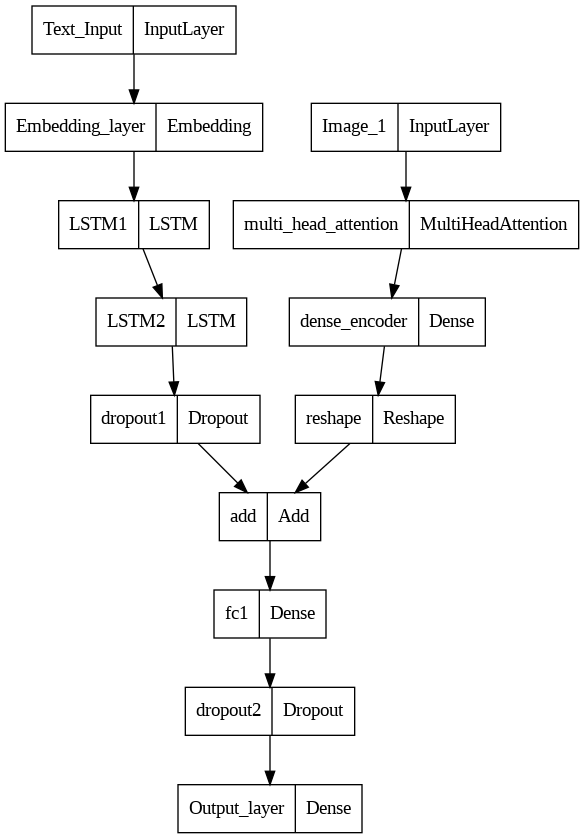

In [30]:
tf.keras.utils.plot_model(encoder_decoder)# plot the model

## Training

In [31]:
optimizer = tf.keras.optimizers.Adam(0.0001)

In [32]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='auto')
#from tensorflow.keras.losses import KLDivergence
#loss_function = KLDivergence()
def maskedLoss(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))

    #calculating the loss
    loss_ = loss_function(y_true, y_pred)

    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)

    #applying the mask to loss
    loss_ = loss_*mask

    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [33]:
encoder_decoder.compile(optimizer, loss = maskedLoss)

In [34]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'Tensorboard/logs_m1/fit3/' + current_time + '/train'
val_log_dir = 'Tensorboard/logs_m1/fit3/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

Training for epochs 1-20

In [35]:
epoch_train_loss = []
epoch_val_loss = []
epoch_=40

for epoch in range(epoch_):
    print('EPOCH : ',epoch+1)
    start = time.time()
    batch_loss_tr = 0
    batch_loss_vl = 0

    for img, report in train_generator:

        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=153, padding='post')
        img_input=tf.reshape(img_input,shape=(img_input.shape[0],img_input.shape[-1]))
        results = encoder_decoder.train_on_batch([img_input, rep_input], output_word)

        batch_loss_tr += results

    train_loss = batch_loss_tr/(X_train.shape[0]//16)
    #14 is the batch size
    #   print('Saving Tensorboard')
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step = epoch)

    for img, report in cv_generator:

        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=153, padding='post')
        img_input=tf.reshape(img_input,shape=(img_input.shape[0],img_input.shape[-1]))
        #output_word=tf.reshape(output_word,shape=(output_word.shape[0],output_word.shape[-1]))
        results = encoder_decoder.test_on_batch([img_input, rep_input], output_word)
        batch_loss_vl += results

    val_loss = batch_loss_vl/(X_cv.shape[0]//16)

    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step = epoch)

    epoch_train_loss.append(train_loss)

    epoch_val_loss.append(val_loss)

    print('Training Loss: {},  Val Loss: {}'.format(train_loss, val_loss))
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))
    encoder_decoder.save_weights('/content/drive/MyDrive/dissertation/Weights_re/embeddingTrain_onelayer_epoch_'+ str(epoch) + '.h5')

EPOCH :  1
Training Loss: 0.003925737348853508,  Val Loss: 0.00343107819036745
Time Taken for this Epoch : 68.60553455352783 sec
EPOCH :  2


KeyboardInterrupt: ignored

In [ ]:
#load weight base=37 epoch
encoder_decoder.load_weights('/content/drive/MyDrive/dissertation/Weights_re/embeddingTrain_onelayer_epoch_9.h5')

In [ ]:
# plot loss function
modelname=" (Base model)"
# Retrieve each dictionary's values
train_values = epoch_train_loss
val_values = epoch_val_loss

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, epoch_)

# Plot and label the training and validation loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss' +  modelname)
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(1, epoch_+1, 2))

# Display the plot
plt.legend(loc='best')
plt.show()



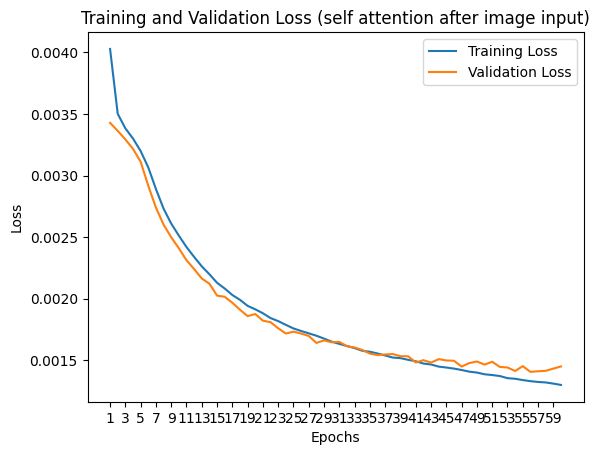

In [ ]:
# plot loss function
modelname=" (self attention after image input)"
# Retrieve each dictionary's values
train_values = epoch_train_loss
val_values = epoch_val_loss

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 60+1)

# Plot and label the training and validation loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss' +  modelname)
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(1, 60+1, 2))

# Display the plot
plt.legend(loc='best')
plt.show()

### Inference Setup

In [ ]:
# base + one attention layer
# encoder
encoder_input = encoder_decoder.input[0]
#encoder_output = encoder_decoder.get_layer('dense_encoder').output
encoder_output = encoder_decoder.get_layer('reshape').output
#encoder_output = tf.reshape(image_features,shape=(image_features.shape[0],image_features.shape[-1]))
encoder_model = Model(encoder_input, encoder_output)

# decoder#
text_input = encoder_decoder.input[1]
enc_output = Input(shape=(256,), name='Enc_Output')
text_output = encoder_decoder.get_layer('LSTM2').output
add1 = tf.keras.layers.Add()([text_output, enc_output])
fc_1 = fc1(add1)
decoder_output = output_layer(fc_1)

decoder_model = Model(inputs = [text_input, enc_output], outputs = decoder_output)

### Greedy Search

In [ ]:
def greedysearch(img):
    image = Xnet_Features[img]
    image = tf.reshape(image,shape=(image.shape[0],image.shape[-1]))
    #image = tf.reshape(image,shape=(1,256))
    input_ = 'startseq'
    image_features = encoder_model.predict(image)
    #print(image_features.shape)

    result = []
    for i in range(153):
        input_tok = [tokenizer.word_index[w] for w in input_.split()]
        input_padded = pad_sequences([input_tok], 153, padding='post')
        image_features = tf.reshape(image_features,shape=(image_features.shape[0],image_features.shape[-1]))
        predictions = decoder_model.predict([input_padded, image_features])
        arg = np.argmax(predictions)
        if arg != 7:   # endseq
            result.append(tokenizer.index_word[arg])
            input_ = input_ + ' ' + tokenizer.index_word[arg]
        else:
            break
    rep = ' '.join(e for e in result)
    return rep

### Beamsearch

In [ ]:

def beamsearch(image, beam_width):

    start = [tokenizer.word_index['startseq']]

    sequences = [[start, 0]]

    img_features = Xnet_Features[image]
    img_features = tf.reshape(img_features,shape=(img_features.shape[0],img_features.shape[-1]))
    #image_features = tf.reshape(image_features,shape=(image_features.shape[0],image_features.shape[-1]))
    img_features = encoder_model.predict(img_features)
    finished_seq = []

    for i in range(153):
        all_candidates = []
        new_seq = []
        for s in sequences:

            text_input = pad_sequences([s[0]], 153, padding='post')
            text_input = tf.reshape(text_input,shape=(text_input.shape[0],text_input.shape[-1]))
            predictions = decoder_model.predict([text_input,img_features])
            top_words = np.argsort(predictions[0])[-beam_width:]
            seq, score = s

            for t in top_words:
                candidates = [seq + [t], score - np.log(predictions[0][t])]
                all_candidates.append(candidates)

        sequences = sorted(all_candidates, key = lambda l: l[1])[:beam_width]
        # checks for 'endseq' in each seq in the beam
        count = 0
        for seq,score in sequences:
            if seq[len(seq)-1] == tokenizer.word_index['endseq']:
                score = score/len(seq)   # normalized
                finished_seq.append([seq, score])
                count+=1
            else:
                new_seq.append([seq, score])
        beam_width -= count
        sequences = new_seq

        # if all the sequences reaches its end before 155 timesteps
        if not sequences:
            break
        else:
            continue

    sequences = finished_seq[-1]
    rep = sequences[0]
    score = sequences[1]
    temp = []
    rep.pop(0)
    for word in rep:
        if word != tokenizer.word_index['endseq']:
            temp.append(tokenizer.index_word[word])
        else:
            break
    rep = ' '.join(e for e in temp)

    return rep, score

## Generate example reports and corresponding true report

In [ ]:
image_atten_beam_output={
    "Image ID":[],
    "Generated report":[],
    "Original report":[]
}

for i in list(range(50)):

  image_atten_beam_output["Image ID"].append(X_test.values[i])
  image_atten_beam_output["Generated report"].append(beamsearch(X_test.values[i], 5)[0])
  image_atten_beam_output["Original report"].append(y_test.values[i])

image_atten_beam_output= pd.DataFrame(image_atten_beam_output)
image_atten_beam_output.to_csv('image_atten_beam_output.csv', index=False)

In [ ]:
base_out={
    "Image ID":[],
    "Generated report":[],
    "Original report":[]
}

for i in list(range(len(X_test)-1)):

  base_out["Image ID"].append(X_test.values[i])
  base_out["Generated report"].append(greedysearch(X_test.values[i]))
  base_out["Original report"].append(y_test.values[i])

base_out= pd.DataFrame(base_out)
base_out.to_csv('base_output.csv', index=False)

In [ ]:
# check some test data
res0 = greedysearch(X_test.values[0])
res1 = greedysearch(X_test.values[1])
res2 = greedysearch(X_test.values[2])
res12 = greedysearch(X_test.values[12])
res100 = greedysearch(X_test.values[100])
res111 = greedysearch(X_test.values[111])
res78 = greedysearch(X_test.values[78])
res90 = greedysearch(X_test.values[90])
res48 = greedysearch(X_test.values[48])
res8 = greedysearch(X_test.values[201])
res7 = greedysearch(X_test.values[72])

some example for base+attention

In [ ]:
res1, res2, res12, res100, res111, res78, res90, res48, res8, res7

('the heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen .',
 'the heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen .',
 'the heart normal size . the mediastinum unremarkable . the lungs are clear .',
 'the heart size and mediastinal contours are within normal limits . the lungs are clear . no pneumothora pleural effusion .',
 'the heart normal size . the mediastinum unremarkable . the lungs are clear .',
 'the heart size and mediastinal contours are within normal limits . the lungs are clear . no pneumothora pleural effusion .',
 'the heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen .',
 'the heart size and mediastinal contours are within normal limits . the lungs are clear . no pneumothora pleu

generation reports through base model

In [ ]:
res1, res2, res12, res100, res111, res78, res90, res48, res8, res7

('the heart size normal . the mediastinum unremarkable . the lungs are clear .',
 'the heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen .',
 'the heart normal size . the mediastinum unremarkable . the lungs are clear .',
 'the heart normal size . the mediastinum unremarkable . the lungs are clear .',
 'the heart normal size . the mediastinum unremarkable . the lungs are clear .',
 'the heart normal size . the mediastinum unremarkable . the lungs are clear .',
 'the heart normal size . the mediastinum unremarkable . the lungs are clear .',
 'the heart normal size . the mediastinum unremarkable . the lungs are clear .',
 'the heart normal size . the mediastinum unremarkable . the lungs are clear .',
 'the heart normal size . the mediastinum unremarkable . the lungs are clear .')

compare with true reports

In [ ]:
#original reports
can0=y_test.values[0]
can1=y_test.values[1]
can2=y_test.values[2]
can12=y_test.values[12]
can100=y_test.values[100]
can111=y_test.values[111]
can78=y_test.values[78]
can90=y_test.values[90]
can48=y_test.values[48]
can8=y_test.values[201]
can7=y_test.values[72]

In [ ]:
can0, can1, can12, can2, can100, can111, can78, can90, can48, can8, can7

('startseq the cardio mediastinal silhouette pulmonary vascular pattern are within normal limits .  no pneumothora .  no pneumonia .  no pleural effusion .  mild degenerative changes mid thoracic spine .  endseq',
 'startseq there no focal consolidation .  there no pneumothora large pleural effusion .  the cardiomediastinal contours are grossly unremarkable .  the heart size within normal limits .  endseq',
 'startseq no focal consolidation .  there are prominent interstitial markings including focally right upper lobe which are similar from prior eamination .  no visualized pneumothora .  the heart size normal .  there are no pleural effusions .  endseq',
 'startseq heart size moderately enlarged .  mild left costophrenic blunting .  streaky and patchy bibasilar opacities left greater than right .  right hemidiaphragm eventration noted .  no typical findings pulmonary edema .  endseq',
 'startseq no focal consolidation pneumothora definite pleural effusion .  heart size within normal 

# evaluation score

Surface-form similarity:
Bleu score is precision-based. It calculates n-gram overlap between the candidate and the reference.The key idea of BLEU is to compute precision by clipping.

Cider score is an image captioning metric that computes cosine similarity between tf–idf weighted n-grams.

ROUGE score is recall base. It computes n-gram based recall for the candidate sentence with respect to the references.

Semantics-form similarity:
Berts score computes the similarity between their tokens' embeddings.



### BLEU SCORE

In [ ]:
def rem_fullstops(text):
    '''Removes punctuations'''
    punctuations = '''.''' # full stop is not removed
    new_text = []
    for char in text:
        if char in punctuations:
            text = text.replace(char, "")
    new_text.append(' '.join(e for e in text.split()))
    return new_text[0]

### CIDER SCORE

In [ ]:
import math
def calculate_cider(reference_sentence, candidate_sentence):
    # Preprocess the sentences
    reference_tokens = nltk.word_tokenize(reference_sentence.lower())
    candidate_tokens = nltk.word_tokenize(candidate_sentence.lower())

    # Compute term frequency (TF) for candidate tokens
    term_frequency = nltk.FreqDist(candidate_tokens)

    # Compute document frequency (DF) for the reference tokens
    document_frequency = nltk.FreqDist(reference_tokens)

    # Compute inverse document frequency (IDF) for each token
    inverse_document_frequency = {
        token: math.log2(len(reference_tokens) / (document_frequency[token] + 1))
        for token in set(reference_tokens)
    }

    # Calculate TF-IDF scores and CIDEr score
    cider_score = 0
    for token in candidate_tokens:
        tf_idf = term_frequency[token] * inverse_document_frequency.get(token, 0)
        cider_score += tf_idf

    cider_score /= len(candidate_tokens)

    return cider_score

# Example usage
reference_sentence = "A cat is sitting on a mat."
candidate_sentence = "A cat is sleeping on a mat."

cider_score = calculate_cider(reference_sentence, candidate_sentence)
print("CIDEr Score:", cider_score)


CIDEr Score: 1.957518749639422


### ROUGE-L SCORE

In [ ]:
def calculate_rouge_l(reference_summary, generated_summary):
    rouge = Rouge()
    scores = rouge.get_scores(generated_summary, reference_summary)
    rouge_l_score = scores[0]['rouge-l']['f']
    return rouge_l_score

### Bert Score

In [ ]:
!pip install torchmetrics
!pip install transformers

In [ ]:
from torchmetrics.text.bert import BERTScore

In [ ]:
bertscore = BERTScore()

# Calculate evaluation scores

## CV dataset

In [ ]:
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
cider = []
rouge_l = []
bert_score = []
for img, rep in tqdm(zip(X_cv.values, y_cv.values)):

    rep = rem_fullstops(rep)
    rep = rep.split()[1:]
    rep = rep[:len(rep)- 1]
    rep = ' '.join(e for e in rep)

    pred_rep = greedysearch(img)
    pred_rep = rem_fullstops(pred_rep)
    print(rep, pred_rep)
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))
    cider.append(calculate_cider(rep, pred_rep))
    rouge_l.append(calculate_rouge_l(rep, pred_rep))
    score= bertscore(rep, pred_rep)
    bert_score.append(score["f1"])

In [ ]:
print('Bleu1 Score: ', sum(bleu1)/X_cv.shape[0])
print('Bleu2 Score: ', sum(bleu2)/X_cv.shape[0])
print('Bleu3 Score: ', sum(bleu3)/X_cv.shape[0])
print('Bleu4 Score: ', sum(bleu4)/X_cv.shape[0])
print('cider: ', sum(cider)/X_cv.shape[0])
print('rouge_l: ', sum(rouge_l)/X_cv.shape[0])

Bleu1 Score:  0.21297539821221598
Bleu2 Score:  0.11821994264992028
Bleu3 Score:  0.07606061645830485
Bleu4 Score:  0.03903942309785743
cider:  nan
rouge_l:  0.2703140104566871


## Test dataset

how can I evaluate the performance of model?
-not only the evaluation metrix
-different paper has total different evaluation metric reuslt, looks unreasonable (intiger or present? If present, score looks reasonable)

In [ ]:
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
cider = []
rouge_l = []
bert_score = []
for img, rep in tqdm(zip(X_test.values[:100], y_test.values[:100])):

    rep = rem_fullstops(rep)
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)

    #pred_rep = greedysearch(img)
    pred_rep = beamsearch(img, 5)
    pred_rep= str(pred_rep)
    #pred_rep = rem_fullstops(pred_rep)

    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))
    cider.append(calculate_cider(rep, pred_rep))
    rouge_l.append(calculate_rouge_l(rep, pred_rep))
    #score= bertscore(rep, pred_rep)
    #bert_score.append(score["f1"])

0it [00:00, ?it/s]

1/1 [==============================] - 0s 36ms/step


1it [00:17, 17.27s/it]

1/1 [==============================] - 0s 23ms/step


2it [00:26, 12.79s/it]

1/1 [==============================] - 0s 21ms/step


3it [00:37, 11.99s/it]

1/1 [==============================] - 0s 35ms/step


4it [00:47, 11.20s/it]

1/1 [==============================] - 0s 20ms/step


5it [00:56, 10.40s/it]

1/1 [==============================] - 0s 25ms/step


6it [01:07, 10.43s/it]

1/1 [==============================] - 0s 41ms/step


7it [01:15,  9.82s/it]

1/1 [==============================] - 0s 22ms/step


8it [01:24,  9.37s/it]

1/1 [==============================] - 0s 32ms/step


9it [01:32,  8.87s/it]

1/1 [==============================] - 0s 21ms/step


10it [01:39,  8.36s/it]

1/1 [==============================] - 0s 33ms/step


11it [01:47,  8.19s/it]

1/1 [==============================] - 0s 21ms/step


12it [01:55,  8.38s/it]

1/1 [==============================] - 0s 36ms/step


13it [02:02,  7.66s/it]

1/1 [==============================] - 0s 23ms/step


14it [02:11,  8.10s/it]

1/1 [==============================] - 0s 23ms/step


15it [02:21,  8.65s/it]

1/1 [==============================] - 0s 37ms/step


16it [02:31,  9.29s/it]

1/1 [==============================] - 0s 26ms/step


17it [02:42,  9.73s/it]

1/1 [==============================] - 0s 21ms/step


18it [02:51,  9.59s/it]

1/1 [==============================] - 0s 27ms/step


19it [02:58,  8.84s/it]

1/1 [==============================] - 0s 20ms/step


20it [03:07,  8.78s/it]

1/1 [==============================] - 0s 30ms/step


21it [03:16,  8.87s/it]

1/1 [==============================] - 0s 20ms/step


22it [03:25,  8.92s/it]

1/1 [==============================] - 0s 31ms/step


23it [03:34,  8.75s/it]

1/1 [==============================] - 0s 22ms/step


24it [03:42,  8.51s/it]

1/1 [==============================] - 0s 21ms/step


25it [03:51,  8.75s/it]

1/1 [==============================] - 0s 21ms/step


26it [03:58,  8.29s/it]

1/1 [==============================] - 0s 25ms/step


27it [04:09,  9.05s/it]

1/1 [==============================] - 0s 32ms/step


28it [04:18,  9.21s/it]

1/1 [==============================] - 0s 24ms/step


29it [04:27,  9.14s/it]

1/1 [==============================] - 0s 20ms/step


30it [04:37,  9.14s/it]

1/1 [==============================] - 0s 21ms/step


31it [04:44,  8.72s/it]

1/1 [==============================] - 0s 23ms/step


32it [04:55,  9.43s/it]

1/1 [==============================] - 0s 33ms/step


33it [05:04,  9.09s/it]

1/1 [==============================] - 0s 31ms/step


34it [05:14,  9.59s/it]

1/1 [==============================] - 0s 21ms/step


35it [05:24,  9.65s/it]

1/1 [==============================] - 0s 40ms/step


36it [05:33,  9.32s/it]

1/1 [==============================] - 0s 25ms/step


37it [05:43,  9.50s/it]

1/1 [==============================] - 0s 22ms/step


38it [05:54,  9.91s/it]

1/1 [==============================] - 0s 31ms/step


39it [06:03,  9.76s/it]

1/1 [==============================] - 0s 21ms/step


40it [06:13,  9.73s/it]

1/1 [==============================] - 0s 22ms/step


41it [06:23, 10.04s/it]

1/1 [==============================] - 0s 21ms/step


42it [06:33,  9.81s/it]

1/1 [==============================] - 0s 29ms/step


43it [06:43,  9.85s/it]

1/1 [==============================] - 0s 31ms/step


44it [06:53,  9.87s/it]

1/1 [==============================] - 0s 21ms/step


45it [07:03,  9.94s/it]

1/1 [==============================] - 0s 26ms/step


46it [07:14, 10.37s/it]

1/1 [==============================] - 0s 32ms/step


47it [07:25, 10.49s/it]

1/1 [==============================] - 0s 23ms/step


48it [07:34, 10.23s/it]

1/1 [==============================] - 0s 21ms/step


49it [07:44, 10.18s/it]

1/1 [==============================] - 0s 41ms/step


50it [07:55, 10.18s/it]

1/1 [==============================] - 0s 21ms/step


51it [08:03,  9.62s/it]

1/1 [==============================] - 0s 23ms/step


52it [08:12,  9.54s/it]

1/1 [==============================] - 0s 24ms/step


53it [08:20,  8.98s/it]

1/1 [==============================] - 0s 22ms/step


54it [08:30,  9.42s/it]

1/1 [==============================] - 0s 31ms/step


55it [08:39,  9.22s/it]

1/1 [==============================] - 0s 22ms/step


56it [08:50,  9.71s/it]

1/1 [==============================] - 0s 21ms/step


57it [09:00,  9.64s/it]

1/1 [==============================] - 0s 22ms/step


58it [09:08,  9.18s/it]

1/1 [==============================] - 0s 21ms/step


59it [09:18,  9.50s/it]

1/1 [==============================] - 0s 33ms/step


60it [09:28,  9.74s/it]

1/1 [==============================] - 0s 32ms/step


61it [09:37,  9.35s/it]

1/1 [==============================] - 0s 22ms/step


62it [09:47,  9.67s/it]

1/1 [==============================] - 0s 34ms/step


63it [09:55,  9.16s/it]

1/1 [==============================] - 0s 31ms/step


64it [10:05,  9.41s/it]

1/1 [==============================] - 0s 34ms/step


65it [10:17, 10.09s/it]

1/1 [==============================] - 0s 27ms/step


66it [10:24,  9.35s/it]

1/1 [==============================] - 0s 21ms/step


67it [10:36, 10.02s/it]

1/1 [==============================] - 0s 36ms/step


68it [10:46, 10.01s/it]

1/1 [==============================] - 0s 22ms/step


69it [10:53,  9.31s/it]

1/1 [==============================] - 0s 21ms/step


70it [11:03,  9.50s/it]

1/1 [==============================] - 0s 34ms/step


71it [11:15, 10.13s/it]

1/1 [==============================] - 0s 21ms/step


72it [11:25,  9.93s/it]

1/1 [==============================] - 0s 22ms/step


73it [11:36, 10.47s/it]

1/1 [==============================] - 0s 32ms/step


74it [11:47, 10.47s/it]

1/1 [==============================] - 0s 26ms/step


75it [11:58, 10.75s/it]

1/1 [==============================] - 0s 21ms/step


76it [12:08, 10.63s/it]

1/1 [==============================] - 0s 31ms/step


77it [12:18, 10.29s/it]

1/1 [==============================] - 0s 21ms/step


78it [12:28, 10.10s/it]

1/1 [==============================] - 0s 26ms/step


79it [12:39, 10.62s/it]

1/1 [==============================] - 0s 36ms/step


80it [12:48,  9.99s/it]

1/1 [==============================] - 0s 25ms/step


81it [13:00, 10.50s/it]

1/1 [==============================] - 0s 24ms/step


82it [13:10, 10.39s/it]

1/1 [==============================] - 0s 36ms/step


83it [13:21, 10.53s/it]

1/1 [==============================] - 0s 24ms/step


84it [13:32, 10.90s/it]

1/1 [==============================] - 0s 29ms/step


85it [13:46, 11.57s/it]

1/1 [==============================] - 0s 33ms/step


86it [13:55, 10.93s/it]

1/1 [==============================] - 0s 23ms/step


87it [14:03, 10.19s/it]

1/1 [==============================] - 0s 22ms/step


88it [14:13, 10.04s/it]

1/1 [==============================] - 0s 32ms/step


89it [14:24, 10.21s/it]

1/1 [==============================] - 0s 21ms/step


90it [14:33,  9.97s/it]

1/1 [==============================] - 0s 22ms/step


91it [14:44, 10.16s/it]

1/1 [==============================] - 0s 24ms/step


92it [14:52,  9.61s/it]

1/1 [==============================] - 0s 23ms/step


93it [15:02,  9.85s/it]

1/1 [==============================] - 0s 42ms/step


94it [15:13, 10.07s/it]

1/1 [==============================] - 0s 23ms/step


95it [15:23,  9.95s/it]

1/1 [==============================] - 0s 33ms/step


96it [15:34, 10.42s/it]

1/1 [==============================] - 0s 31ms/step


97it [15:44, 10.28s/it]

1/1 [==============================] - 0s 24ms/step


98it [15:55, 10.29s/it]

1/1 [==============================] - 0s 21ms/step


99it [16:06, 10.75s/it]

1/1 [==============================] - 0s 32ms/step


100it [16:16,  9.77s/it]


In [ ]:
print('Bleu1 Score: ', sum(bleu1)/99)
print('Bleu2 Score: ', sum(bleu2)/99)
print('Bleu3 Score: ', sum(bleu3)/99)
print('Bleu4 Score: ', sum(bleu4)/99)
print('cider: ', sum(cider)/99)
print('rouge_l: ', sum(rouge_l)/99)

Bleu1 Score:  0.3133607626174864
Bleu2 Score:  0.17939025193937724
Bleu3 Score:  0.09443922802948299
Bleu4 Score:  0.023484059114847602
cider:  1.26864347275316
rouge_l:  0.3542688801375284
